# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.stats.stattools    import jarque_bera

from scipy.stats import yeojohnson, yeojohnson_normmax
from scipy.stats.mstats import winsorize

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings

from pmdarima import auto_arima
from arch import arch_model

from xgboost import XGBRegressor
import shap

from joblib import Parallel, delayed

from tqdm import tqdm

warnings.filterwarnings('ignore')

c:\Users\aatis\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Loading & Visualisation

### Data Loading

In [3]:
# Load the data
etf_data = pd.read_excel('../data/etf_data.xlsx', 
                    index_col=0, parse_dates=True)
macro = pd.read_excel('../data/macro_data.xlsx', 
                      index_col=0, parse_dates=True)

# Check the data
display(etf_data.head())
display(macro.head())

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,SPY,82.933676,83.070128,79.392828,80.614029,1184211500,-0.022421,-0.025290,0.006447,0.002870,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-02-01,SPY,80.675410,83.008700,80.573073,82.299156,1025608400,0.020904,0.018903,0.006730,0.002000,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-03-01,SPY,82.428819,84.086667,79.622469,80.793671,1330548800,-0.018293,-0.019118,0.006339,0.000825,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-04-01,SPY,81.252602,81.684089,77.773173,79.280014,1633318500,-0.018735,-0.020109,0.009503,0.001374,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-05-01,SPY,79.499171,82.362183,78.629331,81.834785,1334647300,0.032225,0.029952,0.006390,0.002273,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True


,vix,michigan_consumer_sentiment_index
2005-01-01,12.82,95.5
2005-02-01,12.08,94.1
2005-03-01,14.02,92.6
2005-04-01,15.31,87.7
2005-05-01,13.29,86.9


In [4]:
# Get information about the data
print("ETF Data Info:")
display(etf_data.describe())
print("\nMacro Data Info:")
display(macro.describe())

ETF Data Info:


,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,Net_Assets_USD,NAV_USD,PE_Ratio,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings
count,9390.000000,9390.000000,9390.000000,9390.000000,9.390000e+03,9390.000000,9390.000000,9390.000000,9390.000000,9.390000e+03,9390.000000,9150.000000,9390.000000,9390.000000,9390.000000,9390,8910.000000,9390.000000
mean,93.092099,97.045423,88.975188,93.649714,2.468733e+08,0.008607,0.014581,0.017699,-0.005974,1.110240e+11,213.909333,122.382739,156.574441,0.978732,19.327796,2000-09-09 16:40:38.338658176,0.004378,509.137061
min,4.405517,5.344534,3.543700,4.580292,3.784000e+05,-0.552338,-0.975610,0.000809,-12.601413,7.002211e+08,51.012780,11.809874,32.000000,0.040000,3.000000,1993-01-22 00:00:00,0.000286,15.000000
25%,30.231473,31.666174,28.763775,30.399909,1.700618e+07,-0.018344,-0.022689,0.007402,0.000029,7.565434e+09,83.582250,20.031942,97.000000,0.920000,8.000000,1998-12-16 00:00:00,0.003120,41.000000
50%,57.109226,59.123289,54.899310,57.499956,5.617620e+07,0.011291,0.011616,0.010382,0.001313,2.197420e+10,155.905620,24.043083,131.000000,1.020000,19.000000,2000-05-22 00:00:00,0.005046,106.000000
75%,105.229672,108.498752,100.907749,105.674837,1.734420e+08,0.038996,0.039894,0.015204,0.002807,6.210832e+10,294.072970,28.588177,196.000000,1.150000,24.000000,2000-11-13 00:00:00,0.006060,638.000000
max,1119.092382,1155.303518,1032.653371,1121.264038,1.188235e+10,0.441413,12.600001,2.715833,0.988050,1.822973e+12,602.602500,3746.136500,395.000000,1.470000,45.000000,2011-12-20 00:00:00,0.007566,3559.000000
std,111.421460,117.086308,105.276264,111.862251,6.403065e+08,0.054746,0.235992,0.075203,0.230123,3.079992e+11,155.744395,594.803294,88.417300,0.282054,11.918402,NaN,0.002252,778.059300



Macro Data Info:


,vix,michigan_consumer_sentiment_index
count,240.000000,240.000000
mean,19.299542,80.122083
std,8.250237,12.798809
min,9.510000,50.000000
25%,13.535000,70.450000
50%,16.810000,80.200000
75%,22.990000,91.550000
max,59.889999,101.400000


### Plots

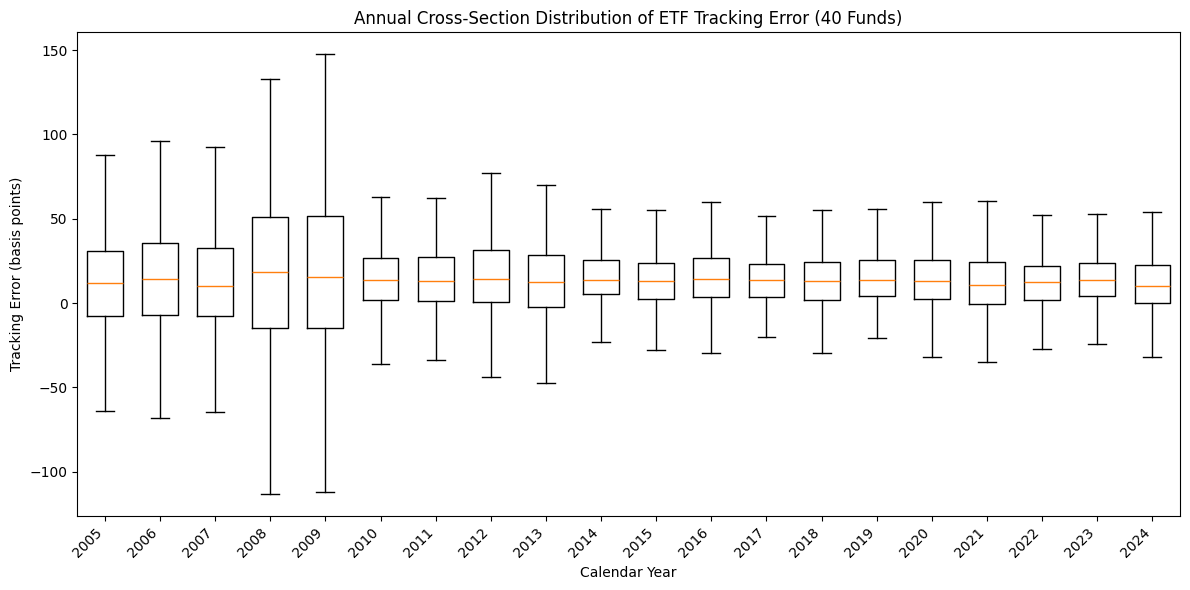

In [6]:
# 1 · Convert each calendar year’s 40 values from decimal → bp (×10 000)
ys_lists_bp = (
    etf_data
        .groupby(etf_data.index.year)['Tracking_Error']
        .apply(lambda x: (x * 10_000).tolist())      # decimal → bp
)

# 2 · Draw the strip of yearly box-plots
fig, ax = plt.subplots(figsize=(12, 6))

positions = range(len(ys_lists_bp))
ax.boxplot(
    ys_lists_bp.tolist(),
    positions=positions,
    widths=0.65,
    showfliers=False        # flip to True if you’d like the individual outlier dots
)

ax.set_xticks(positions)
ax.set_xticklabels([str(y) for y in ys_lists_bp.index], rotation=45, ha='right')

ax.set_title('Annual Cross-Section Distribution of ETF Tracking Error (40 Funds)')
ax.set_xlabel('Calendar Year')
ax.set_ylabel('Tracking Error (basis points)')
plt.tight_layout()
plt.show()

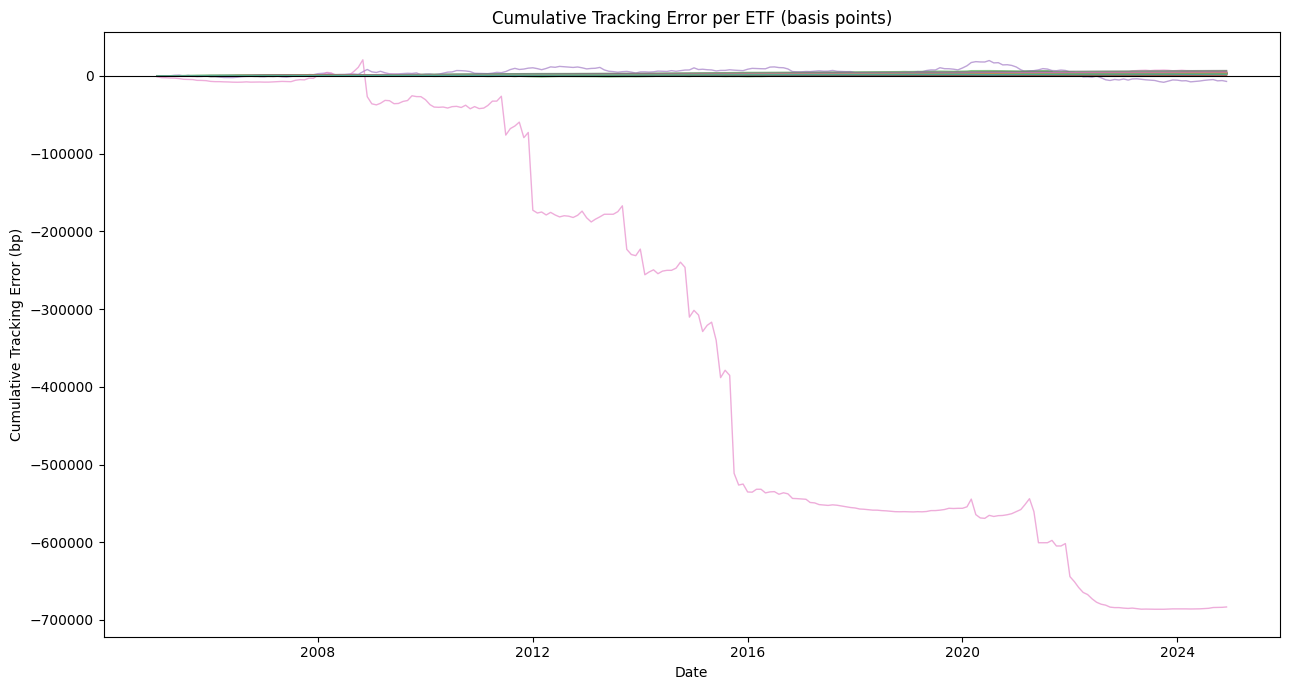

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------
# 1 ▸  Convert decimal tracking error to basis-points
# ------------------------------------------------------------
df = etf_data.copy()
df['TE_bp'] = df['Tracking_Error'] * 10_000        # e.g. 0.002 → 20 bp

# ------------------------------------------------------------
# 2 ▸  Running cumulative TE for each ETF
# ------------------------------------------------------------
df = df.sort_values(['ETF_Ticker', 'Date'])         # chronological within each fund
df['Cum_TE_bp'] = df.groupby('ETF_Ticker')['TE_bp'].cumsum()

# ------------------------------------------------------------
# 3 ▸  Long → wide with duplicates handled safely
#     • If an ETF has >1 record stamped with the same Date,
#       keep the *last* one (change to 'mean' if preferred).
# ------------------------------------------------------------
wide = (
    df.pivot_table(index='Date',
                   columns='ETF_Ticker',
                   values='Cum_TE_bp',
                   aggfunc='last')
      .sort_index()                                 # ensure dates ascend
)

# ------------------------------------------------------------
# 4 ▸  Plot: one semi-transparent line per ETF
# ------------------------------------------------------------
plt.figure(figsize=(13, 7))

for col in wide.columns:
    plt.plot(wide.index,
             wide[col],
             linewidth=1,
             alpha=0.6)

plt.axhline(0, color='black', linewidth=0.8)
plt.title('Cumulative Tracking Error per ETF (basis points)')
plt.xlabel('Date')
plt.ylabel('Cumulative Tracking Error (bp)')
plt.tight_layout()
plt.show()


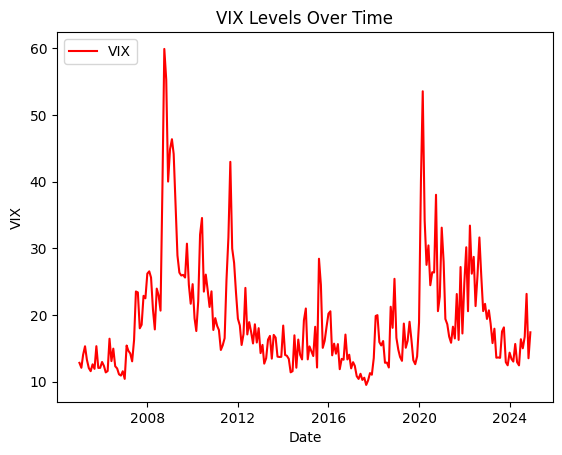

In [11]:
# VIX 
fig, ax1 = plt.subplots()
ax1.plot(macro['vix'], label='VIX', color='r')
ax1.set_xlabel('Date'); ax1.set_ylabel('VIX')

lines1, labs1 = ax1.get_legend_handles_labels()
ax1.legend(lines1, labs1, loc='upper left')
plt.title('VIX Levels Over Time')
plt.show()

# SARIMA-GARCH Model Fitting

### Transforms & Inverses Functions

In [ ]:
def winsorize_yj(
    series: pd.Series,
    limits: tuple = (0.01, 0.01)
) -> tuple[np.ndarray, dict]:
    """
    Winsorizes the series, shifts it to be strictly positive, 
    and applies the Yeo-Johnson transformation.

    Parameters
    ----------
    series : pd.Series
        Input time series to transform.
    limits : tuple, default (0.01, 0.01)
        Tuple specifying the lower and upper percentile limits 
        for winsorization.

    Returns
    -------
    transformed : np.ndarray
        Transformed series after winsorization, shift, and Yeo-Johnson transform.
    params : dict
        Dictionary containing the transformation parameters:
        - 'lambda': Optimal lambda for the Yeo-Johnson transformation.
        - 'shift': Amount added to shift data to strictly positive.
    """
    w = winsorize(series.values, limits=limits)  # Winsorize outliers
    s_w = pd.Series(w, index=series.index)

    shift = -s_w.min() + 1e-6  # Ensure data is strictly positive
    shifted = s_w + shift

    lam = yeojohnson_normmax(shifted)  # Find optimal lambda
    transformed = yeojohnson(shifted, lmbda=lam)

    return transformed, {"lambda": lam, "shift": shift}


def inv_yj(arr: np.ndarray, params: dict) -> np.ndarray:
    """
    Applies the inverse of the Yeo-Johnson transformation.

    Parameters
    ----------
    arr : np.ndarray
        Transformed array to invert.
    params : dict
        Dictionary containing transformation parameters:
        - 'lambda': Lambda used during the forward transformation.
        - 'shift': Shift applied before transformation.

    Returns
    -------
    y : np.ndarray
        Original array, inverse-transformed and unshifted.
    """
    lam = params["lambda"]
    sh = params["shift"]

    x = np.asarray(arr, dtype=float)
    y = np.zeros_like(x)

    # Positive branch of the inverse
    pos = x >= 0
    if lam != 0:
        y[pos] = np.power(x[pos] * lam + 1, 1 / lam) - 1
    else:
        y[pos] = np.exp(x[pos]) - 1

    # Negative branch of the inverse
    neg = x < 0
    if lam != 2:
        y[neg] = 1 - np.power(-x[neg] * (2 - lam) + 1, 1 / (2 - lam))
    else:
        y[neg] = 1 - np.exp(-x[neg])

    return y - sh

### SARIMA-GARCH Model

In [ ]:
def fit_sarima_garch(
    series: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
) -> dict:
    """
    Fits a SARIMA model with expanding-window cross-validation, and
    optionally visualizes the final CV fold with GARCH-based 95% confidence intervals.

    Parameters
    ----------
    series : pd.Series
        Time series to model.
    horizon : int
        Forecast horizon (steps ahead).
    cv_window : int
        Initial training window for expanding-window CV.
    cv_step : int
        Step size between CV folds.
    winsor_limits : tuple
        Winsorization limits for outlier treatment.
    seasonal_period : int
        Seasonal period for SARIMA.
    n_jobs : int
        Number of parallel jobs for CV folds.
    arima_jobs : int
        Number of parallel jobs inside each auto_arima fit.
    max_pq : int
        Maximum AR/MA and SAR/SMA order.
    max_dD : int
        Maximum differencing order (regular and seasonal).
    forecast_plot : bool
        If True, plots final CV fold forecast with GARCH 95% CI.

    Returns
    -------
    dict
        Dictionary containing:
        - 'cv_metrics': Cross-validation performance metrics (MAE, MSE, R2).
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Data Preparation and Window Setup
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()

    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    # Define fold endpoints for expanding-window CV
    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Logic
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        train = y.iloc[:end]
        test  = y.iloc[end:end + horizon]

        # Transform training set (winsorize + Yeo-Johnson)
        tr_t, tf_par = winsorize_yj(train, winsor_limits)

        # Fit SARIMA via auto_arima
        model = auto_arima(
            tr_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )

        # Forecast and inverse-transform
        forecast = inv_yj(model.predict(horizon), tf_par)

        # Return error metrics
        return (
            mean_absolute_error(test, forecast),
            mean_squared_error(test, forecast),
            r2_score(test, forecast)
        )

    # ─────────────────────────────────────────────────────────────
    # 2. Run CV Across All Folds in Parallel
    # ─────────────────────────────────────────────────────────────
    mae, mse, r2 = map(
        list,
        zip(*Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends))
    )

    # Aggregate CV results
    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ─────────────────────────────────────────────────────────────
    # 3. Plot Final Fold Forecast with GARCH Confidence Intervals
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        end   = fold_ends[-1]
        train = y.iloc[:end]
        test  = y.iloc[end:end + horizon]

        # Fit SARIMA on final training fold
        tr_t, tf_par = winsorize_yj(train, winsor_limits)
        model = auto_arima(
            tr_t,
            seasonal=True, m=seasonal_period,
            information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20,
            suppress_warnings=True, error_action="ignore",
            n_jobs=arima_jobs,
        )
        fc = inv_yj(model.predict(horizon), tf_par)

        # Fit GARCH(1,1) to SARIMA residuals
        resid = pd.Series(model.arima_res_.resid,
                          index=train.index[-len(model.arima_res_.resid):])
        z = resid / resid.std()

        gmod = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
        var_h   = gmod.forecast(horizon=horizon, reindex=False).variance.iloc[-1].values
        sigma_f = np.sqrt(var_h) * resid.std()

        # Plot the last 10 points + forecast horizon
        prev_n   = 10
        idx_prev = y.index[-(prev_n + horizon): -horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev], test.values],
                 "-o", color="C0", zorder=2, label="Actual")
        plt.plot(np.r_[idx_prev, test.index],
                 np.r_[y.loc[idx_prev].values, fc],
                 "--o", color="C1", zorder=1, label="Forecast")
        plt.errorbar(test.index, fc, yerr=1.96 * sigma_f,
                     fmt="none", ecolor="grey", alpha=0.5,
                     capsize=5, label="GARCH 95% CI")

        plt.title(f"Final CV Fold: SARIMA–GARCH Actual Values + {horizon}-Step Forecast")
        plt.xlabel("Date")
        plt.ylabel(series.name or "Value")
        plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 4. Return Cross-Validation Metrics
    # ─────────────────────────────────────────────────────────────
    return {"cv_metrics": cv_metrics}


In [ ]:
# Fit SARIMA–GARCH model and collect CV metrics
sarima_results = fit_sarima_garch(
    qqq["Tracking_Error"],
    horizon=3,
    cv_window=60,
    cv_step=30,
    forecast_plot=True
)

NameError: name 'qqq' is not defined

In [ ]:
# Create cross-validation results table (per fold)
sarima_cv_df = pd.DataFrame({
    "Fold": range(1, sarima_results["cv_metrics"]["folds"] + 1),
    "MAE":  sarima_results["cv_metrics"]["MAE"]["values"],
    "MSE":  sarima_results["cv_metrics"]["MSE"]["values"],
    "R2":   sarima_results["cv_metrics"]["R2"]["values"],
})

In [ ]:
# Display formatted table
print("\n=== Cross-Validation Results ===")
display(sarima_cv_df.style.format("{:.6f}"))

# Print average performance across all CV folds
print("Average Metrics Across Folds:")
print(f"\nMAE mean ± std : {sarima_results['cv_metrics']['MAE']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['MAE']['std']:.6f}")
print(f"MSE mean ± std : {sarima_results['cv_metrics']['MSE']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['MSE']['std']:.6f}")
print(f"R2  mean ± std : {sarima_results['cv_metrics']['R2']['mean']:.6f} ± "
      f"{sarima_results['cv_metrics']['R2']['std']:.6f}")


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000461,0.000000,0.690880
1,2.000000,0.001213,0.000002,0.059212
2,3.000000,0.000685,0.000001,0.152457
3,4.000000,0.001679,0.000003,-0.218612
4,5.000000,0.002026,0.000006,-0.196126
5,6.000000,0.000208,0.000000,0.597187
6,7.000000,0.000360,0.000000,0.545101


Average Metrics Across Folds:

MAE mean ± std : 0.000947 ± 0.000651
MSE mean ± std : 0.000002 ± 0.000002
R2  mean ± std : 0.232871 ± 0.351423


# MS-SARIMA (VIX Switch) Model Fitting

### VIX Visualisation & Regime Fit

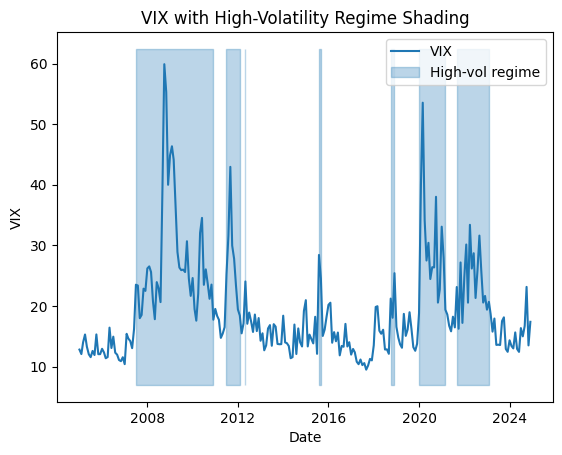

In [ ]:
# Extract VIX series from macro data
vix = macro['vix']

# Fit a 2-state Markov switching model on VIX time series
ms_model = MarkovRegression(vix, k_regimes=2, trend='c', switching_variance=True)
ms_res = ms_model.fit(disp=False)

# Extract smoothed probability of high-volatility regime
#    (Assume regime 1 corresponds to high volatility)
s = ms_res.smoothed_marginal_probabilities.iloc[:, 1]


# Plot VIX and overlay shading for high-volatility periods
fig, ax = plt.subplots()
x = vix.index

# Plot the VIX time series
line, = ax.plot(x, vix.values, label='VIX')

# Get vertical axis bounds for shading
ymin, ymax = ax.get_ylim()

# Shade regions where high-volatility regime probability > 0.35
ax.fill_between(
    x,
    ymin,
    ymax,
    where=(s > 0.35),
    color=line.get_color(),
    alpha=0.3,
    label='High-vol regime'
)

# Set axis labels and plot title
ax.set_xlabel('Date')
ax.set_ylabel('VIX')
ax.set_title('VIX with High-Volatility Regime Shading')

# Show legend
ax.legend(loc='upper right')

# Display plot
plt.show()

### VIX Series Standardisation

In [ ]:
# Variance-stabilizing transformation using sqrt-log
vix_pre = np.sqrt(np.log1p(vix))

# Z-score standardisation
vix_std = (vix_pre - vix_pre.mean()) / vix_pre.std()

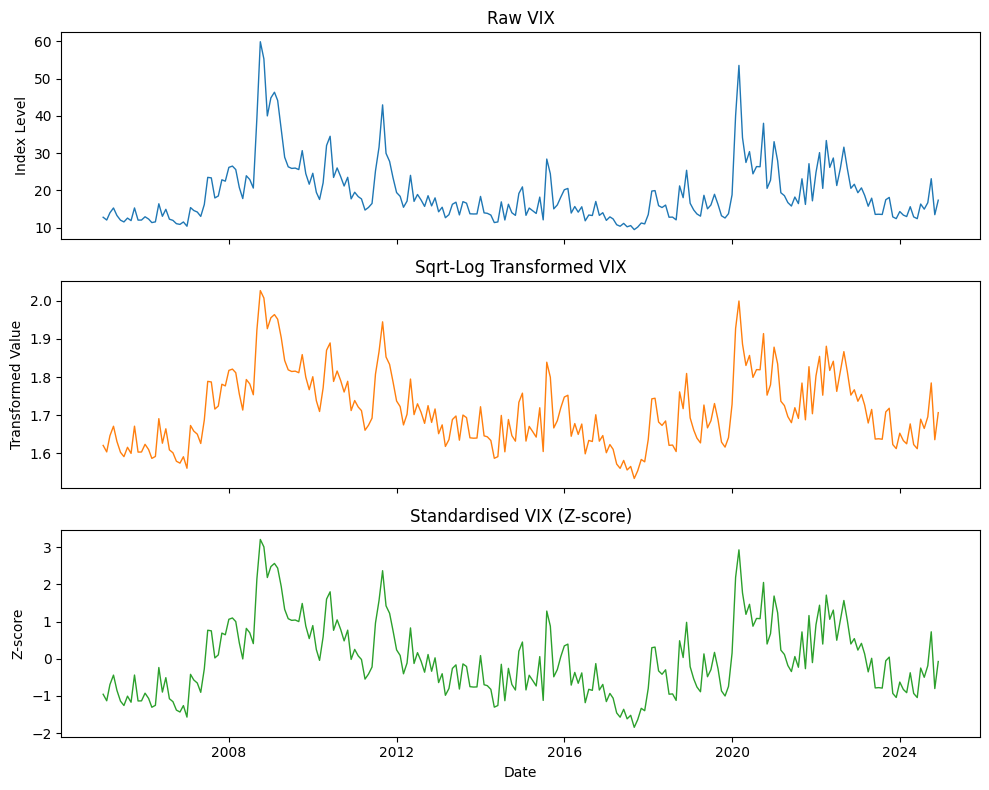

In [ ]:
# Plot each series in its own vertical subplot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

# Plot 1 – Raw VIX
axes[0].plot(vix.index, vix, color='C0', lw=1)
axes[0].set_title("Raw VIX")
axes[0].set_ylabel("Index Level")

# Plot 2 – Variance-stabilized (sqrt-log)
axes[1].plot(vix_pre.index, vix_pre, color='C1', lw=1)
axes[1].set_title("Sqrt‑Log Transformed VIX")
axes[1].set_ylabel("Transformed Value")

# Plot 3 – Z-score standardised VIX
axes[2].plot(vix_std.index, vix_std, color='C2', lw=1)
axes[2].set_title("Standardised VIX (Z-score)")
axes[2].set_ylabel("Z-score")
axes[2].set_xlabel("Date")

# Adjust layout
plt.tight_layout()
plt.show()

### MS SARIMA Model

In [ ]:
def fit_ms_sarima_vix(
    series: pd.Series,
    vix: pd.Series,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    winsor_limits: tuple = (0.01, 0.01),
    seasonal_period: int = 12,
    regime_thresh: float = 0.5,
    n_jobs: int = -1,
    arima_jobs: int = 1,
    max_pq: int = 5,
    max_dD: int = 3,
    forecast_plot: bool = True,
    alpha: float = 0.05,
):
    """
    Fit a two-regime Markov-Switching SARIMA model driven by VIX to forecast ETF tracking errors.

    The model:
    - Splits SARIMA training by estimated VIX regimes (high vs low volatility)
    - Uses expanding-window cross-validation
    - Computes MAE, MSE, R² across CV folds
    - Runs residual diagnostics on final training window
    - Optionally plots final forecast with GARCH-based confidence intervals

    Parameters
    ----------
    series : pd.Series
        Target time series (e.g. tracking error).
    vix : pd.Series
        Exogenous volatility index to infer regimes from.
    horizon : int
        Forecast horizon (in periods).
    cv_window : int
        Initial training window size.
    cv_step : int
        Step size between validation folds.
    winsor_limits : tuple
        Lower and upper limits for Yeo-Johnson + Winsorization transform.
    seasonal_period : int
        Seasonal period (e.g. 12 for monthly seasonality).
    regime_thresh : float
        Threshold for regime assignment using smoothed probabilities.
    n_jobs : int
        Number of parallel jobs for CV.
    arima_jobs : int
        Number of parallel jobs within pmdarima ARIMA fitting.
    max_pq : int
        Max p/q and P/Q values for SARIMA.
    max_dD : int
        Max d/D differencing orders for SARIMA.
    forecast_plot : bool
        If True, plot final-fold forecast with regime shading and GARCH CI.
    alpha : float
        Significance level for residual diagnostic Pass/Fail flags.

    Returns
    -------
    dict
        Dictionary with keys:
            - "cv_metrics": dict with MAE, MSE, R² values across folds
            - "residual_tests": dict with Ljung-Box, Jarque-Bera, ARCH LM stats
    """

    # ─────────────────────────────────────────────────────────────
    # 0. Prepare series and define expanding CV folds
    # ─────────────────────────────────────────────────────────────
    y = series.dropna()
    v = vix.reindex_like(y).ffill()

    if len(y) < cv_window + horizon:
        raise ValueError("Series too short for chosen cv_window + horizon.")

    fold_ends = list(range(cv_window, len(y) - horizon + 1, cv_step))
    if fold_ends[-1] != len(y) - horizon:
        fold_ends.append(len(y) - horizon)

    # ─────────────────────────────────────────────────────────────
    # Helper: Fit SARIMA with Yeo-Johnson + Winsor transform
    # ─────────────────────────────────────────────────────────────
    def _sarima_fit(ts):
        ts_t, tf_par = winsorize_yj(ts, winsor_limits)
        mod = auto_arima(
            ts_t, seasonal=True, m=seasonal_period, information_criterion="bic",
            max_p=max_pq, max_q=max_pq, max_d=max_dD,
            max_P=max_pq, max_Q=max_pq, max_D=max_dD,
            stepwise=True, maxiter=20, suppress_warnings=True,
            error_action="ignore", n_jobs=arima_jobs
        )
        fc = inv_yj(mod.predict(horizon), tf_par)
        return mod, tf_par, fc

    # ─────────────────────────────────────────────────────────────
    # Helper: Estimate regime probabilities and transition matrix
    # ─────────────────────────────────────────────────────────────
    def _regimes(v_sub):
        res = MarkovRegression(v_sub, k_regimes=2, trend="c",
                               switching_variance=True).fit(disp=False)
        p00, p10 = res.params["p[0->0]"], res.params["p[1->0]"]
        P = np.array([[p00, 1-p00], [p10, 1-p10]])  # transition matrix
        prob_high = res.smoothed_marginal_probabilities.iloc[:, 1]
        return prob_high, P

    # ─────────────────────────────────────────────────────────────
    # 1. Cross-Validation Fold Worker
    # ─────────────────────────────────────────────────────────────
    def _cv_fold(end):
        y_tr, y_te = y.iloc[:end], y.iloc[end:end+horizon]
        prob, P = _regimes(v.iloc[:end])
        flag = prob > regime_thresh

        if flag.all() or (~flag).all():  # Only one regime → shared model
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr)
            hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
        else:  # Split training data by inferred regime
            lo_mod, lo_tf, lo_fc = _sarima_fit(y_tr.loc[~flag])
            hi_mod, hi_tf, hi_fc = _sarima_fit(y_tr.loc[ flag])

        # Predict each horizon step using forward probabilities
        p_vec = np.array([1 - prob.iloc[-1], prob.iloc[-1]])  # last state
        fc_mix = []
        for h in range(horizon):
            p_vec = p_vec @ P
            fc_mix.append(p_vec[0]*lo_fc[h] + p_vec[1]*hi_fc[h])

        return (mean_absolute_error(y_te, fc_mix),
                mean_squared_error(y_te, fc_mix),
                r2_score(y_te, fc_mix))

    # Run CV folds in parallel
    mae, mse, r2 = map(
        list, zip(*Parallel(n_jobs=n_jobs)(delayed(_cv_fold)(e) for e in fold_ends))
    )
    cv_metrics = {
        "folds": len(mae),
        "MAE": {"values": mae, "mean": np.mean(mae), "std": np.std(mae)},
        "MSE": {"values": mse, "mean": np.mean(mse), "std": np.std(mse)},
        "R2":  {"values": r2,  "mean": np.mean(r2),  "std": np.std(r2)},
    }

    # ─────────────────────────────────────────────────────────────
    # 2. Final Fit + Residual Diagnostics (for GARCH etc.)
    # ─────────────────────────────────────────────────────────────
    tr_y, te_y = y.iloc[:-horizon], y.iloc[-horizon:]
    prob_f, P_f = _regimes(v.iloc[:-horizon])
    flag_f = prob_f > regime_thresh

    if flag_f.all() or (~flag_f).all():
        lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y)
        hi_mod, hi_tf, hi_fc = lo_mod, lo_tf, lo_fc
    else:
        lo_mod, lo_tf, lo_fc = _sarima_fit(tr_y.loc[~flag_f])
        hi_mod, hi_tf, hi_fc = _sarima_fit(tr_y.loc[ flag_f])

    # Merge fitted values across regimes
    lo_fit = inv_yj(lo_mod.predict_in_sample(), lo_tf)
    hi_fit = inv_yj(hi_mod.predict_in_sample(), hi_tf)
    fitted = pd.Series(index=tr_y.index, dtype=float)
    fitted.loc[~flag_f] = lo_fit
    fitted.loc[ flag_f] = hi_fit
    resid = tr_y - fitted

    # ─────────────────────────────────────────────────────────────
    # 3. Residual Diagnostics (Ljung-Box, JB, ARCH-LM)
    # ─────────────────────────────────────────────────────────────
    lb_stat, lb_p = acorr_ljungbox(resid, lags=[10], return_df=True).iloc[0]
    jb_stat, jb_p = jarque_bera(resid)[:2]
    arch_stat, arch_p, *_ = het_arch(resid, nlags=10)

    residual_tests = {
        "Serial_LB(Q10)": {"stat": lb_stat,   "p": lb_p,
                           "Result": "Fail" if lb_p < alpha else "Pass"},
        "Normality_JB":   {"stat": jb_stat,   "p": jb_p,
                           "Result": "Fail" if jb_p < alpha else "Pass"},
        "ARCH_LM(10)":    {"stat": arch_stat, "p": arch_p,
                           "Result": "Fail" if arch_p < alpha else "Pass"},
    }

    print("\n=== Residual Diagnostics ===")
    for k, d in residual_tests.items():
        print(f"{k:15s} stat={d['stat']:.3f}  p={d['p']:.4f}  → {d['Result']}")

    # ─────────────────────────────────────────────────────────────
    # 4. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        def _sigma(mod, sub_series):
            """Estimate forecast std using GARCH(1,1) on normalized residuals."""
            resid = pd.Series(mod.arima_res_.resid,
                              index=sub_series.index[-len(mod.arima_res_.resid):])
            z = resid / resid.std()
            gfit = arch_model(z, vol="Garch", p=1, q=1, dist="t", rescale=False).fit(disp="off")
            var_h = gfit.forecast(horizon=horizon, reindex=False).variance.iloc[-1]
            return np.sqrt(var_h) * resid.std()

        sig_lo = _sigma(lo_mod, tr_y.loc[~flag_f] if (~flag_f).any() else tr_y)
        sig_hi = _sigma(hi_mod, tr_y.loc[ flag_f] if  flag_f.any()  else tr_y)

        # Combine regime-conditional forecasts and variance
        p_vec = np.array([1 - prob_f.iloc[-1], prob_f.iloc[-1]])
        fc_mix, sigma_mix = [], []
        for h in range(horizon):
            p_vec = p_vec @ P_f
            fc_mix.append(p_vec[0] * lo_fc[h] + p_vec[1] * hi_fc[h])
            sigma_mix.append(np.sqrt(p_vec[0] * sig_lo[h]**2 + p_vec[1] * sig_hi[h]**2))

        # Plot: forecast vs actual, GARCH CI, and regime shading
        prev_n   = 10
        idx_prev = y.index[-(prev_n + horizon):-horizon]

        plt.figure(figsize=(10, 4))
        plt.plot(np.r_[idx_prev, te_y.index], np.r_[y.loc[idx_prev], te_y.values],
                 "-o", color="C0", label="Actual", zorder=2)
        plt.plot(np.r_[idx_prev, te_y.index], np.r_[y.loc[idx_prev].values, fc_mix],
                 "--o", color="C1", label="Forecast", zorder=1)
        plt.errorbar(te_y.index, fc_mix, yerr=1.96 * np.array(sigma_mix),
                     fmt="none", ecolor="grey", alpha=0.5, capsize=5,
                     label="GARCH 95% CI")

        shade = pd.concat([
            prob_f.iloc[-prev_n:],
            pd.Series([p_vec[1]] * horizon, index=te_y.index)
        ])
        ymin, ymax = plt.ylim()
        plt.fill_between(shade.index, ymin, ymax, where=shade > regime_thresh,
                         color="C2", alpha=0.3, label="High-Vol Regime")

        plt.title(f"Final CV Fold: MS-SARIMA ({horizon}-step)")
        plt.xlabel("Date"); plt.ylabel(series.name or "Value"); plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 5. Return Results
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "residual_tests": residual_tests
    }



=== Residual Diagnostics ===
Serial_LB(Q10)  stat=61.933  p=0.0000  → Fail
Normality_JB    stat=413.340  p=0.0000  → Fail
ARCH_LM(10)     stat=51.218  p=0.0000  → Fail


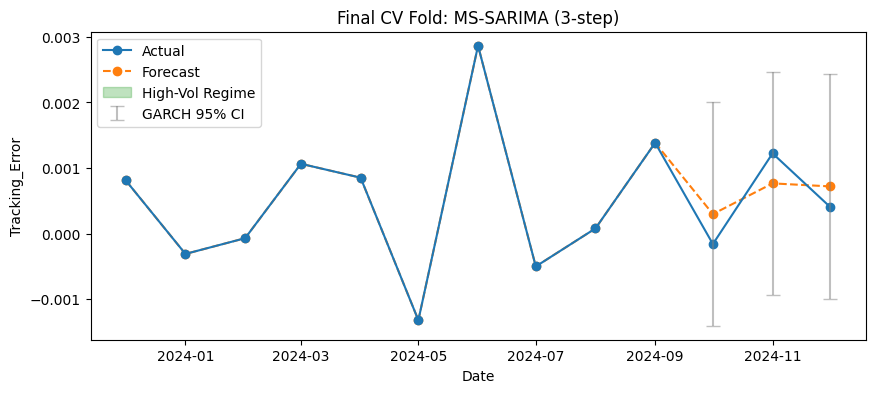

In [ ]:
# Fit MS-VIX-SARIMA model and collect CV metrics
ms_vix_sarima_results = fit_ms_sarima_vix(
    series = qqq["Tracking_Error"],
    vix    = vix_std,
    horizon=3,
    cv_window=60,
    cv_step=30,
    regime_thresh=0.5,
    forecast_plot=True
)

In [ ]:
# Create cross-validation results table
print("\n=== Cross-Validation Results ===")
ms_vix_sarima_cv_df = pd.DataFrame({
    "Fold": range(1, ms_vix_sarima_results["cv_metrics"]["folds"] + 1),
    "MAE":  ms_vix_sarima_results["cv_metrics"]["MAE"]["values"],
    "MSE":  ms_vix_sarima_results["cv_metrics"]["MSE"]["values"],
    "R2":   ms_vix_sarima_results["cv_metrics"]["R2"]["values"],
})
display(ms_vix_sarima_cv_df.style.format("{:.6f}"))

# Print average metrics across folds
for k in ["MAE", "MSE", "R2"]:
    print(f"{k} mean ± std : {ms_vix_sarima_results['cv_metrics'][k]['mean']:.6f} ± "
          f"{ms_vix_sarima_results['cv_metrics'][k]['std']:.6f}")


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.000461,0.000000,0.685963
1,2.000000,0.001208,0.000002,0.075923
2,3.000000,0.000628,0.000000,0.264587
3,4.000000,0.001595,0.000003,-0.099267
4,5.000000,0.001847,0.000005,0.039148
5,6.000000,0.000174,0.000000,0.771037
6,7.000000,0.000410,0.000000,0.464571


MAE mean ± std : 0.000903 ± 0.000599
MSE mean ± std : 0.000002 ± 0.000002
R2 mean ± std : 0.314566 ± 0.310613


All three residual diagnostics fail (p < 0.05), indicating the MS-VIX-SARIMA + GARCH model has not purged all predictable structure.

Ljung-Box Q(10) detects short-run autocorrelation; Jarque-Bera flags heavy-tailed, non-Gaussian errors; ARCH-LM(10) reveals remaining volatility clustering.

These results point to remaining non-linear and interaction effects—e.g., asymmetric responses to VIX spikes, ETF-specific frictions—that classical linear/regime models cannot express.

As such, later a XGBoost will be fit to the residuals of this model.

# Gradient Boosted Decision Tree Model Fitting

### Loading Data

In [ ]:
etf_data = pd.read_excel('../data/etf_data.xlsx', 
                    index_col=0, parse_dates=True)

In [ ]:
etf_data.head()

,ETF_Ticker,ETF_Open,ETF_High,ETF_Low,ETF_Close,ETF_Volume,ETF_Return,Benchmark_Return,Benchmark_Volatility,Tracking_Error,...,Dividend_Yield_pct,Beta,Expense_Ratio_pct,Fund_Family,Fund_Category,Inception_Date,Pct_in_Top10_Holdings,Total_Holdings,Optionable,Shortable
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,SPY,82.933676,83.070128,79.392828,80.614029,1184211500,-0.022421,-0.025290,0.006447,0.002870,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-02-01,SPY,80.675410,83.008700,80.573073,82.299156,1025608400,0.020904,0.018903,0.006730,0.002000,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-03-01,SPY,82.428819,84.086667,79.622469,80.793671,1330548800,-0.018293,-0.019118,0.006339,0.000825,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-04-01,SPY,81.252602,81.684089,77.773173,79.280014,1633318500,-0.018735,-0.020109,0.009503,0.001374,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True
2005-05-01,SPY,79.499171,82.362183,78.629331,81.834785,1334647300,0.032225,0.029952,0.006390,0.002273,...,121.0,1.01,9.45,SPDR State Street Global Advisors,Large Blend,1993-01-22,0.003573,504,True,True


### Helper Functions

In [ ]:
def make_features(df, target="Tracking_Error", lags=(1, 2, 3)):
    """
    Generate lagged numeric features and integer-coded categorical variables from ETF dataset.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing time series and static features for multiple ETFs.
    target : str
        Name of the target column to predict (default is "Tracking_Error").
    lags : tuple of int
        Lag values to create for all numeric columns.

    Returns
    -------
    X : pd.DataFrame
        Feature matrix including lagged variables and integer-encoded categorical variables.
    y : pd.Series
        Target variable aligned with X.
    df : pd.DataFrame
        Cleaned and augmented full DataFrame (with ETF_Ticker, Date, etc.).
    """
    df = df.copy()

    # Ensure presence of a "Date" column
    if "Date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "Date"})
        else:
            raise KeyError("Need a Date column or datetime index.")

    # Sort to ensure correct lagging
    df = df.sort_values(["ETF_Ticker", "Date"])

    # Add lagged versions of all numeric columns
    num_cols = df.select_dtypes(include="number").columns.tolist()
    for col in num_cols:
        for l in lags:
            df[f"{col}_lag{l}"] = df.groupby("ETF_Ticker")[col].shift(l)

    # Preserve string ticker, but add an integer code
    df["ETF_code"] = pd.Categorical(df["ETF_Ticker"]).codes.astype("int32")

    # Convert all other categorical columns to integer codes
    cat_cols = [c for c in df.columns if c not in num_cols + ["Date", "ETF_Ticker", "ETF_code"]]
    for col in cat_cols:
        df[col] = pd.Categorical(df[col]).codes.astype("int32")

    # Drop columns with only one unique value and rows with missing values
    nunq = df.nunique(dropna=True)
    df = df.drop(columns=nunq[nunq <= 1].index).dropna()

    # Split features and target
    X = df.drop(columns=[target, "Date", "ETF_Ticker"])  # Keep ETF_code
    y = df[target]
    return X, y, df

In [ ]:
def report_cv(cv):
    """
    Display cross-validation fold results and print mean ± std for each metric.

    Parameters
    ----------
    cv : dict
        Dictionary containing keys: 'folds', and nested metrics (MAE, MSE, R2),
        each with 'values', 'mean', and 'std'.
    """
    print("\n=== Cross-Validation Results ===")
    
    # Display table of metrics for each fold
    cv_df = pd.DataFrame({
        "Fold": range(1, cv["folds"] + 1),
        "MAE":  cv["MAE"]["values"],
        "MSE":  cv["MSE"]["values"],
        "R2":   cv["R2"]["values"],
    })
    display(cv_df.style.format("{:.6f}"))

    # Print mean ± std for each metric
    for k in ["MAE", "MSE", "R2"]:
        print(f"{k} mean ± std : {cv[k]['mean']:.6f} ± {cv[k]['std']:.6f}")

### XGBoost Model Fit

In [ ]:
def fit_xgboost(
    df: pd.DataFrame,
    horizon: int = 3,
    cv_window: int = 60,
    cv_step: int = 30,
    xgb_params: dict | None = None,
    forecast_plot: bool = True,
    plot_ticker: str | None = None,
    top_n_importance: int = 20,
):
    """
    Run expanding-window XGBoost backtest with SHAP and per-ETF metrics.

    Parameters
    ----------
    df : pd.DataFrame
        Input data containing time series + static ETF features (must include 'Tracking_Error').
    horizon : int
        Forecasting horizon in steps (e.g. 3-month ahead).
    cv_window : int
        Initial window length for expanding-window CV.
    cv_step : int
        Number of time steps between CV folds.
    xgb_params : dict or None
        Optional override for default XGBoost hyperparameters.
    forecast_plot : bool
        Whether to plot forecast vs actual for one ETF at the final fold.
    plot_ticker : str or None
        Optional ETF ticker to highlight in the forecast plot.
    top_n_importance : int
        How many top features to display in feature importance and SHAP plots.

    Returns
    -------
    dict containing:
        - cv_metrics: dict of mean ± std for MAE, MSE, R2
        - cv_fold_df: pd.DataFrame of fold-wise metrics
        - feature_importance_df: pd.Series of gain-based feature importances
        - per_etf_metrics: pd.DataFrame of per-ETF MAE/MSE/R2 ± std
        - learning_curve: dict of train/valid RMSE across rounds
        - shap_values: np.ndarray of SHAP values
        - shap_sample_X: pd.DataFrame of sampled input features for SHAP
    """
    # ─────────────────────────────────────────────────────────────
    # 1. Preprocessing: Lag creation + category encoding
    # ─────────────────────────────────────────────────────────────
    X_full, y_full, full = make_features(df)
    dates = np.sort(full["Date"].unique())

    # ─────────────────────────────────────────────────────────────
    # 2. Set Expanding CV Fold Boundaries
    # ─────────────────────────────────────────────────────────────
    fold_ends = list(range(cv_window, len(dates) - horizon + 1, cv_step))
    if fold_ends[-1] != len(dates) - horizon:
        fold_ends.append(len(dates) - horizon)

    # ─────────────────────────────────────────────────────────────
    # 3. Define XGBoost Hyperparameters
    # ─────────────────────────────────────────────────────────────
    params = dict(
        objective="reg:squarederror", n_estimators=600, learning_rate=0.05,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        tree_method="hist", enable_categorical=True, n_jobs=-1,
        random_state=0, eval_metric=["rmse"]
    )
    if xgb_params:
        params.update(xgb_params)

    mae_vals, mse_vals, r2_vals = [], [], []

    # ─────────────────────────────────────────────────────────────
    # 4. Expanding-Window Cross-Validation Loop
    # ─────────────────────────────────────────────────────────────
    for pos in tqdm(fold_ends, desc="CV folds", unit="fold"):
        train_dates = dates[:pos+1]
        valid_dates = dates[pos+1:pos+1+horizon]

        tr_mask = full["Date"].isin(train_dates)
        va_mask = full["Date"].isin(valid_dates)

        model = XGBRegressor(**params).fit(X_full.loc[tr_mask], y_full.loc[tr_mask])
        preds = model.predict(X_full.loc[va_mask])

        mae_vals.append(mean_absolute_error(y_full.loc[va_mask], preds))
        mse_vals.append(mean_squared_error(y_full.loc[va_mask], preds))
        r2_vals .append(r2_score        (y_full.loc[va_mask], preds))

    cv_metrics = {
        "folds": len(mae_vals),
        "MAE": {"values": mae_vals, "mean": np.mean(mae_vals), "std": np.std(mae_vals)},
        "MSE": {"values": mse_vals, "mean": np.mean(mse_vals), "std": np.std(mse_vals)},
        "R2":  {"values": r2_vals,  "mean": np.mean(r2_vals),  "std": np.std(r2_vals)},
    }

    # ─────────────────────────────────────────────────────────────
    # 5. Fit Final Model on Last Training Window
    # ─────────────────────────────────────────────────────────────
    pos = fold_ends[-1]
    train_dates = dates[:pos+1]
    valid_dates = dates[pos+1:pos+1+horizon]
    tr_mask = full["Date"].isin(train_dates)
    va_mask = full["Date"].isin(valid_dates)

    final_model = XGBRegressor(**params).fit(
        X_full.loc[tr_mask], y_full.loc[tr_mask],
        eval_set=[(X_full.loc[tr_mask], y_full.loc[tr_mask]),
                  (X_full.loc[va_mask], y_full.loc[va_mask])],
        verbose=False
    )
    preds_final = final_model.predict(X_full.loc[va_mask])

    # ─────────────────────────────────────────────────────────────
    # 6. Global Feature Importance (Gain)
    # ─────────────────────────────────────────────────────────────
    imp_series = pd.Series(
        final_model.get_booster().get_score(importance_type="gain"),
        name="gain"
    ).sort_values(ascending=False)

    top_imp = imp_series.head(top_n_importance)
    plt.figure(figsize=(10, 0.35*len(top_imp)+1))
    top_imp[::-1].plot(kind="barh", color="C1")
    plt.title(f"Top {len(top_imp)} Features by Gain")
    plt.xlabel("Gain"); plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 7. SHAP Summary Plot
    # ─────────────────────────────────────────────────────────────
    sample_idx = np.random.choice(X_full.shape[0], size=min(5000, X_full.shape[0]), replace=False)
    shap_sample_X = X_full.iloc[sample_idx]
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(shap_sample_X)

    shap.summary_plot(
        shap_values, shap_sample_X,
        show=False, max_display=top_n_importance,
        plot_size=(10, 6)
    )
    plt.title("SHAP Value Summary Plot (Top Features)")
    plt.tight_layout(); plt.show()

    # ─────────────────────────────────────────────────────────────
    # 8. Final Fold: Per-ETF MAE, MSE, R^2 ± std
    # ─────────────────────────────────────────────────────────────
    rows = []
    valid_full = full.loc[va_mask].copy()
    valid_full["pred"] = preds_final

    for etf, g in valid_full.groupby("ETF_Ticker"):
        err = g["Tracking_Error"] - g["pred"]
        rows.append([
            etf,
            err.abs().mean(),  err.abs().std(ddof=0),
            (err**2).mean(),   (err**2).std(ddof=0),
            r2_score(g["Tracking_Error"], g["pred"]),
        ])

    per_df = pd.DataFrame(rows, columns=[
        "ETF", "MAE", "MAE_std", "MSE", "MSE_std", "R2"
    ]).set_index("ETF").sort_index()

    display(per_df.style.format("{:.6f}"))

    # ─────────────────────────────────────────────────────────────
    # 9. Extract Learning Curve from Final Fit
    # ─────────────────────────────────────────────────────────────
    ev = final_model.evals_result_
    learning_curve = {
        "train_rmse": ev["validation_0"]["rmse"],
        "valid_rmse": ev["validation_1"]["rmse"],
    }

    # ─────────────────────────────────────────────────────────────
    # 10. Optional Final Fold Forecast Plot
    # ─────────────────────────────────────────────────────────────
    if forecast_plot:
        ticker = plot_ticker or per_df.index[0]
        mask_ticker = full["ETF_Ticker"] == ticker

        act = full.loc[va_mask & mask_ticker, ["Date", "Tracking_Error"]].copy()
        act["Forecast"] = preds_final[mask_ticker[va_mask].values]

        hist = full.loc[tr_mask & mask_ticker, ["Date", "Tracking_Error"]].tail(10)

        plt.figure(figsize=(10, 4))
        # Forecast (underneath)
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Forecast"]]),
                 "--o", label="Forecast", color="C1", zorder=1)
        # Actual (on top)
        plt.plot(pd.concat([hist["Date"], act["Date"]]),
                 pd.concat([hist["Tracking_Error"], act["Tracking_Error"]]),
                 "-o", label="Actual", color="C0", zorder=2)
        plt.title(f"Final CV Fold: XGBoost Forecast ({horizon}-step)")
        plt.xlabel("Date"); plt.ylabel("Tracking Error"); plt.legend()
        plt.show()

    # ─────────────────────────────────────────────────────────────
    # 11. Return All Results in a Dictionary
    # ─────────────────────────────────────────────────────────────
    return {
        "cv_metrics": cv_metrics,
        "cv_fold_df": pd.DataFrame({
            "Fold": range(1, len(mae_vals)+1),
            "MAE":  mae_vals,
            "MSE":  mse_vals,
            "R2":   r2_vals
        }).set_index("Fold"),
        "feature_importance_df": imp_series,
        "per_etf_metrics": per_df,
        "learning_curve": learning_curve,
        "shap_values": shap_values,
        "shap_sample_X": shap_sample_X,
    }

CV folds: 100%|██████████| 7/7 [00:17<00:00,  2.51s/fold]


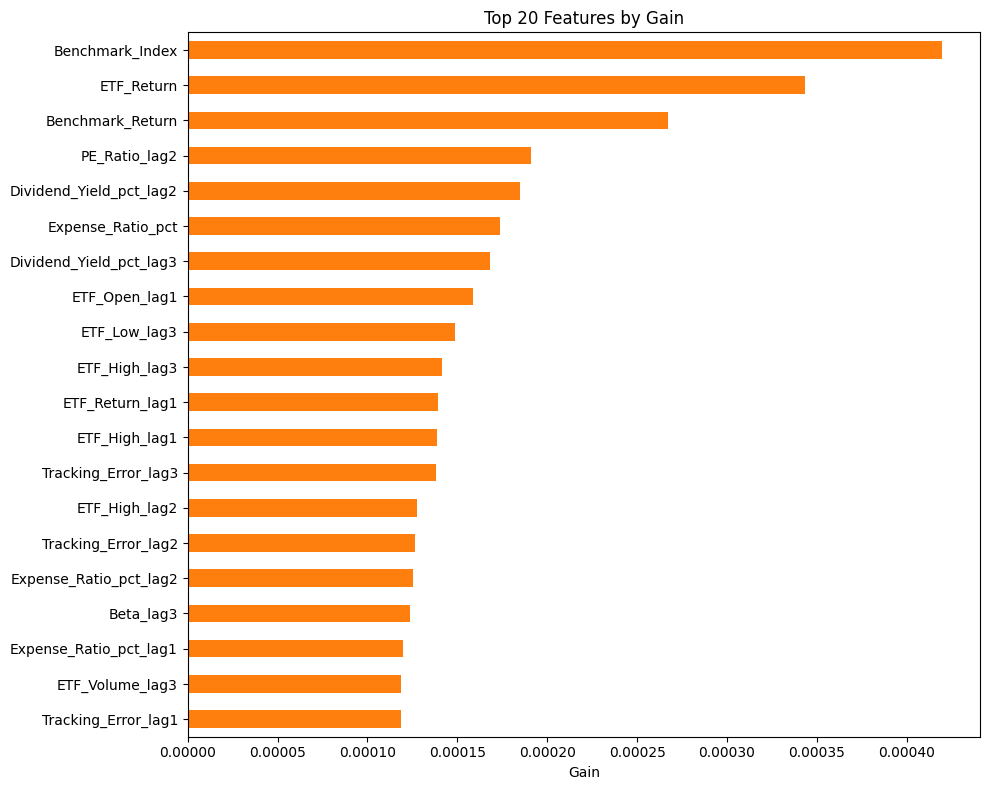

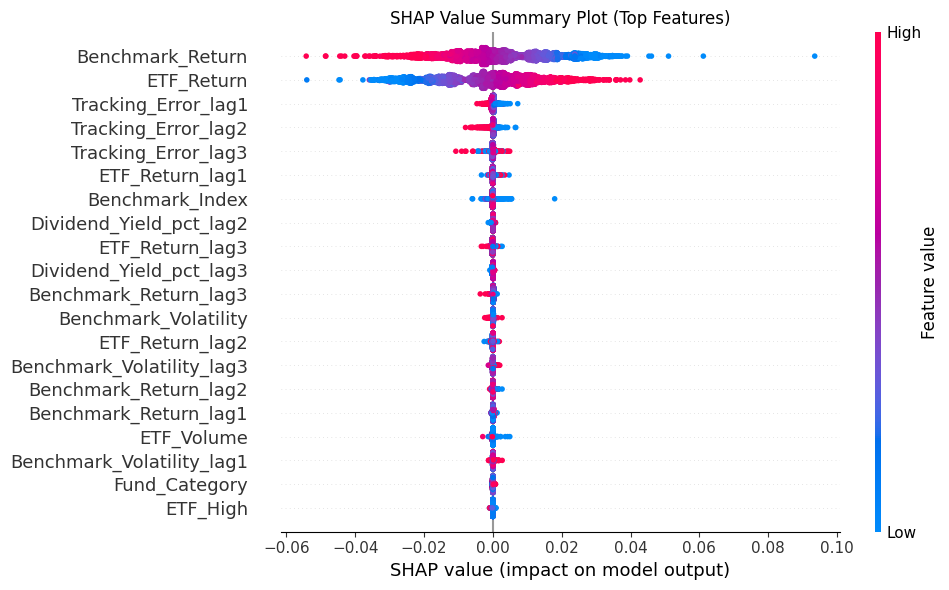

,MAE,MAE_std,MSE,MSE_std,R2
ETF,,,,,
DIA,0.000115,0.000012,0.000000,0.000000,0.988713
IBB,0.005532,0.004166,0.000048,0.000046,-21.496721
IDU,0.002393,0.001469,0.000008,0.000007,-0.667590
IJH,0.000788,0.000411,0.000001,0.000001,0.292339
IJR,0.001197,0.000534,0.000002,0.000001,0.441352
IVV,0.000224,0.000070,0.000000,0.000000,0.772453
IWB,0.000283,0.000019,0.000000,0.000000,0.869364
IWD,0.000326,0.000189,0.000000,0.000000,0.842538
IWF,0.000472,0.000427,0.000000,0.000000,-3.236991


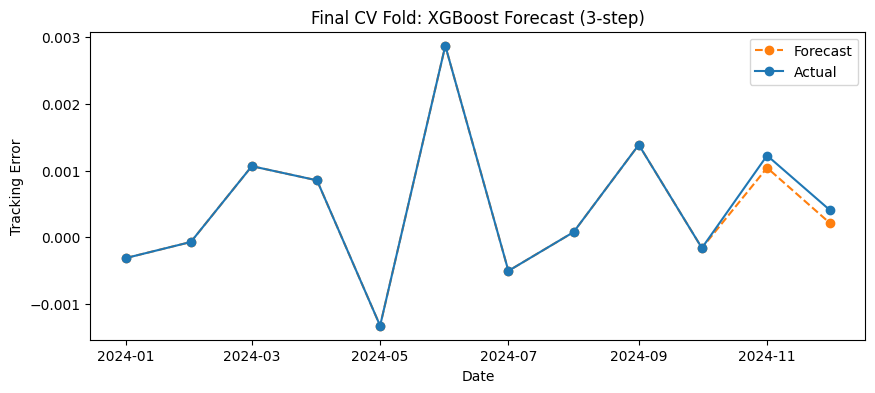

In [ ]:
xgboost_results = fit_xgboost(
    etf_data,
    horizon=3,
    cv_window=60,
    cv_step=30,
    forecast_plot=True,      
    plot_ticker="QQQ",        
    top_n_importance=20      
)


=== Cross-Validation Results ===


,Fold,MAE,MSE,R2
0,1.000000,0.002119,0.000020,0.633845
1,2.000000,0.001419,0.000005,0.776883
2,3.000000,0.001035,0.000004,0.749485
3,4.000000,0.000953,0.000004,0.631774
4,5.000000,0.004725,0.000199,0.169327
5,6.000000,0.002270,0.000031,0.601379
6,7.000000,0.001583,0.000007,0.826426


MAE mean ± std : 0.002015 ± 0.001198
MSE mean ± std : 0.000038 ± 0.000066
R2 mean ± std : 0.627017 ± 0.202636

=== Learning Curve ===


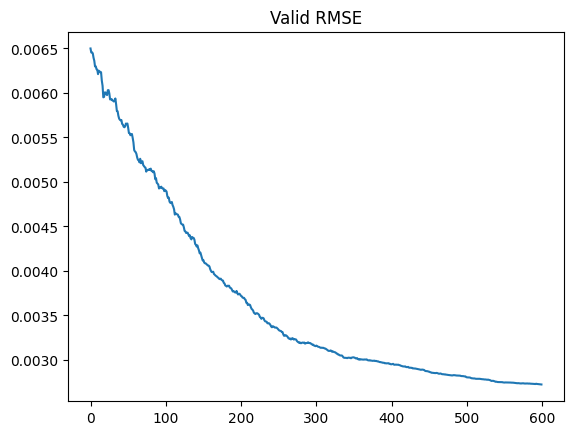

In [ ]:
# Display cross-validation results
report_cv(xgboost_results["cv_metrics"])

# learning curve
print("\n=== Learning Curve ===")
plt.plot(xgboost_results["learning_curve"]["valid_rmse"]); plt.title("Valid RMSE"); plt.show()